In [1]:
# =====================================================
# HÜCRE 1 – KÜTÜPHANELERİ YÜKLE (REGRESYON)
# Bu hücre:
# 1) Temel, sklearn, xgboost ve PyTorch kütüphanelerini yükler
# 2) Uyarı mesajlarını gizler
# =====================================================

import warnings
warnings.filterwarnings('ignore')

# Temel kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn modelleri ve yardımcı fonksiyonlar
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)
from scipy.sparse import hstack
from xgboost import XGBRegressor

# PyTorch kütüphaneleri
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print("Tüm kütüphaneler başarıyla yüklendi.")


Tüm kütüphaneler başarıyla yüklendi.


In [3]:
# =====================================================
# HÜCRE 2 – VERİ YÜKLEME VE SADECE HOURLY İLANLARIN SEÇİLMESİ
# Bu hücre:
# 1) CSV dosyasını okur
# 2) Başlığı boş satırları temizler
# 3) is_hourly sütununu 0/1 olarak kodlar
# 4) Sadece Hourly ilanları filtreler
# =====================================================

csv_path = "all_upwork_jobs_2024-02-07-2024-03-24.csv"

df = pd.read_csv(csv_path, low_memory=False)

df = df.dropna(subset=["title"]).copy()

def map_hourly(v):
    s = str(v).strip().lower()
    if s in ["1", "true", "yes", "y", "hourly"]:
        return 1
    if s in ["0", "false", "no", "n", "fixed"]:
        return 0
    return np.nan

df["is_hourly"] = df["is_hourly"].apply(map_hourly)
df = df.dropna(subset=["is_hourly"]).copy()
df["is_hourly"] = df["is_hourly"].astype(int)

# Sadece hourly ilanlar tutulur
df = df[df["is_hourly"] == 1].copy()

print(f"Veri Seti Boyutu ): {df.shape}")


Veri Seti Boyutu ): (140936, 8)


In [4]:
# =====================================================
# HÜCRE 3 – SAYISAL ÖZELLİK MÜHENDİSLİĞİ
# Bu hücre:
# 1) Başlık uzunluğu ve kelime sayısını hesaplar
# 2) Bütçe ve saatlik ücret var mı bilgisini çıkarır
# 3) Ortalama saatlik ücreti ve doldurulmuş bütçe değerlerini ekler
# 4) Ülke bilgisini kategorik → sayısal hale getirir
# =====================================================

df["title_length"] = df["title"].astype(str).str.len()
df["word_count"] = df["title"].astype(str).str.split().str.len()

df["has_budget"] = df["budget"].notna().astype(int)
df["has_hourly"] = df["hourly_low"].notna().astype(int)

# Hedef olacak ortalama saatlik ücret
df["avg_hourly"] = df[["hourly_low", "hourly_high"]].mean(axis=1)

df = df.dropna(subset=["avg_hourly"]).copy()

df["budget_filled"] = df["budget"].fillna(0)

top_countries = df["country"].value_counts().head(10).index.tolist()
df["country_grouped"] = df["country"].apply(
    lambda x: x if x in top_countries else "Other"
)
df["country_grouped"] = df["country_grouped"].fillna("Unknown")

le_country = LabelEncoder()
df["country_encoded"] = le_country.fit_transform(df["country_grouped"])

print("Sayısal özellikler oluşturuldu")
print("\nÜretilen özellikler:")
print(" - title_length, word_count")
print(" - has_budget, has_hourly")
print(" - avg_hourly, budget_filled")
print(" - country_encoded")


Sayısal özellikler oluşturuldu

Üretilen özellikler:
 - title_length, word_count
 - has_budget, has_hourly
 - avg_hourly, budget_filled
 - country_encoded


In [5]:
# =====================================================
# HÜCRE 4 – METİN ÖZELLİKLERİ (TF-IDF)
# Bu hücre:
# 1) İş başlıklarını TF-IDF vektörlerine dönüştürür
# 2) 1500 en sık ve bilgilendirici kelimeyi kullanır
# =====================================================

tfidf = TfidfVectorizer(max_features=1500, stop_words="english")
X_text = tfidf.fit_transform(df["title"].astype(str))

print(f"TF-IDF matris boyutu: {X_text.shape}")
print(" - 1500 farklı kelime seçildi")
print(f" - {df.shape[0]:,} belge işlendi")


TF-IDF matris boyutu: (102422, 1500)
 - 1500 farklı kelime seçildi
 - 102,422 belge işlendi


In [6]:
# =====================================================
# HÜCRE 5 – TÜM ÖZELLİKLERİN BİRLEŞTİRİLMESİ VE HEDEFİN TANIMLANMASI
# Bu hücre:
# 1) Sayısal özellikleri seçer
# 2) TF-IDF matrisini bu sayısal özelliklerle birleştirir
# 3) Son X matrisini ve y hedef vektörünü oluşturur
# =====================================================

numeric_cols = [
    "title_length", "word_count", "has_budget",
    "has_hourly", "country_encoded", "avg_hourly", "budget_filled"
]

X_numeric = df[numeric_cols].values
X = hstack([X_text, X_numeric])

# Hedef değişken: avg_hourly (saatlik ücret)
y = df["avg_hourly"].astype(float).values

print("Tüm özellikler birleştirildi")
print("\nSon özellik matrisi:")
print(f" - Boyut: {X.shape[0]:,} örnek × {X.shape[1]} özellik")
print(" - 1500 TF-IDF + 7 sayısal = 1507 toplam özellik")
print(f"Hedef değişken: avg_hourly (örnek sayısı = {y.shape[0]:,})")


Tüm özellikler birleştirildi

Son özellik matrisi:
 - Boyut: 102,422 örnek × 1507 özellik
 - 1500 TF-IDF + 7 sayısal = 1507 toplam özellik
Hedef değişken: avg_hourly (örnek sayısı = 102,422)


In [7]:
# =====================================================
# HÜCRE 6 – TRAIN/TEST AYIRIMI (REGRESYON)
# Bu hücre:
# 1) X ve y'yi eğitim ve test setlerine böler
# 2) Rastgelelik kontrolü için random_state sabit tutulur
# =====================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Veri bölünmesi tamamlandı")
print(f" Eğitim Seti: {X_train.shape[0]:,} örnek")
print(f" Test Seti:   {X_test.shape[0]:,} örnek")


# =====================================================
# YARDIMCI FONKSİYON – REGRESYON METRİKLERİNİN HESAPLANMASI
# Bu fonksiyon:
# - R2, MSE, RMSE, MAE, MAPE metriklerini hesaplar.
# =====================================================

def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(
        np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))
    ) * 100
    r2 = r2_score(y_true, y_pred)
    return r2, mse, rmse, mae, mape


Veri bölünmesi tamamlandı
 Eğitim Seti: 81,937 örnek
 Test Seti:   20,485 örnek


In [8]:
# =====================================================
# HÜCRE 7 – SKLEARN REGRESYON MODELLERİ (GBR, RF, XGBR)
# Bu hücre:
# 1) GradientBoostingRegressor
# 2) RandomForestRegressor
# 3) XGBRegressor
# modellerini cv=3 ve daraltılmış parametre aralıkları ile eğitir.
# Her model için R2, MSE, RMSE, MAE, MAPE metriklerini hesaplar ve kaydeder.
# =====================================================

print("\n" + "="*70)
print("SKLEARN REGRESYON MODELLERİ - GRIDSEARCHCV İLE HİPERPARAMETRE ARAMA")
print("="*70)

sklearn_results = []

print("\nGradientBoostingRegressor eğitiliyor...")

gbr_params = {
    "n_estimators": [100, 150],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5]
}

gbr = GradientBoostingRegressor(random_state=42)

gbr_grid = GridSearchCV(
    gbr,
    gbr_params,
    cv=3,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)
gbr_grid.fit(X_train, y_train)

y_pred_gbr = gbr_grid.best_estimator_.predict(X_test)
r2, mse, rmse, mae, mape = regression_metrics(y_test, y_pred_gbr)

sklearn_results.append({
    "Model": "GradientBoostingRegressor",
    "R2": r2,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape
})

print("En iyi GBR parametreleri:", gbr_grid.best_params_)


print("\nRandomForestRegressor eğitiliyor...")

rf_params = {
    "n_estimators": [100],
    "max_depth": [15, 20],
    "min_samples_split": [5]
}

rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_grid = GridSearchCV(
    rf_reg,
    rf_params,
    cv=3,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)
rf_grid.fit(X_train, y_train)

y_pred_rf = rf_grid.best_estimator_.predict(X_test)
r2, mse, rmse, mae, mape = regression_metrics(y_test, y_pred_rf)

sklearn_results.append({
    "Model": "RandomForestRegressor",
    "R2": r2,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape
})

print("En iyi RF parametreleri:", rf_grid.best_params_)


print("\nXGBRegressor eğitiliyor...")

xgbr_params = {
    "n_estimators": [100, 150],
    "learning_rate": [0.05, 0.1],
    "max_depth": [5]
}

xgbr = XGBRegressor(
    random_state=42,
    objective="reg:squarederror",
    n_jobs=-1
)

xgbr_grid = GridSearchCV(
    xgbr,
    xgbr_params,
    cv=3,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)
xgbr_grid.fit(X_train, y_train)

y_pred_xgbr = xgbr_grid.best_estimator_.predict(X_test)
r2, mse, rmse, mae, mape = regression_metrics(y_test, y_pred_xgbr)

sklearn_results.append({
    "Model": "XGBRegressor",
    "R2": r2,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape
})

print("En iyi XGBR parametreleri:", xgbr_grid.best_params_)

sklearn_df = pd.DataFrame(sklearn_results).round(4)
print("\nSKLEARN REGRESYON MODELLERİ PERFORMANSI")
print(sklearn_df.to_string(index=False))

sklearn_df.to_csv("ayham_sklearn_regression_models.csv", index=False)
print("\nKaydedildi: ayham_sklearn_regression_models.csv")



SKLEARN REGRESYON MODELLERİ - GRIDSEARCHCV İLE HİPERPARAMETRE ARAMA

GradientBoostingRegressor eğitiliyor...
En iyi GBR parametreleri: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}

RandomForestRegressor eğitiliyor...
En iyi RF parametreleri: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}

XGBRegressor eğitiliyor...
En iyi XGBR parametreleri: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

SKLEARN REGRESYON MODELLERİ PERFORMANSI
                    Model     R2     MSE   RMSE    MAE   MAPE
GradientBoostingRegressor 0.9998  0.1562 0.3952 0.0721 0.2666
    RandomForestRegressor 0.9999  0.1090 0.3302 0.0054 0.0014
             XGBRegressor 0.9427 51.5608 7.1806 0.5564 1.2948

Kaydedildi: ayham_sklearn_regression_models.csv


In [9]:
# =====================================================
# HÜCRE 8 – PYTORCH İÇİN VERİ HAZIRLAMA (REGRESYON)
# Bu hücre:
# 1) X_train/X_test'i dense formata dönüştürür
# 2) StandardScaler ile ölçekler
# 3) PyTorch Dataset ve DataLoader oluşturur
# 4) Kayıp fonksiyonu olarak MSELoss seçilir
# =====================================================

print("\n" + "="*70)
print("PYTORCH DERİN ÖĞRENME REGRESYON MODELLERİ")
print("="*70)

X_train_dense = X_train.toarray().astype(np.float32)
X_test_dense = X_test.toarray().astype(np.float32)

y_train_np = y_train.astype(np.float32)
y_test_np = y_test.astype(np.float32)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled = scaler.transform(X_test_dense)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("İşlemci:", device)

pytorch_results = []
loss_fn = nn.MSELoss()

train_dataset = TensorDataset(
    torch.FloatTensor(X_train_scaled),
    torch.FloatTensor(y_train_np.reshape(-1, 1))
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)



PYTORCH DERİN ÖĞRENME REGRESYON MODELLERİ
İşlemci: cpu


In [10]:
# =====================================================
# HÜCRE 9 – PYTORCH MLP VE LSTM REGRESYON MODELLERİ
# Bu hücre:
# 1) MLP modelini tanımlar ve 5 epoch boyunca eğitir
# 2) LSTM modelini tanımlar ve 5 epoch boyunca eğitir
# 3) Her iki model için test seti üzerinde R2, MSE, RMSE, MAE, MAPE metriklerini hesaplar
# 4) Sonuçları CSV dosyasına kaydeder
# =====================================================

print("\n1) MLP (Multi-Layer Perceptron) Regresyon Modeli eğitiliyor...")

class MLPModel(nn.Module):
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x

mlp_model = MLPModel(X_train_scaled.shape[1]).to(device)
optim_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

mlp_model.train()
for epoch in range(5):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optim_mlp.zero_grad()
        out = mlp_model(X_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        optim_mlp.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/5 - Ortalama Kayıp (MSE): {epoch_loss/len(train_loader):.4f}")

mlp_model.eval()
with torch.no_grad():
    y_pred_mlp = mlp_model(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy().flatten()

r2, mse, rmse, mae, mape = regression_metrics(y_test_np, y_pred_mlp)
pytorch_results.append({
    "Model": "MLP",
    "Mimari": "128-64-1",
    "R2": r2,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape
})

print("MLP eğitimi tamamlandı.")

print("\n2) LSTM (Long Short-Term Memory) Regresyon Modeli eğitiliyor...")

class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=64,
            batch_first=True,
            num_layers=1
        )
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        _, (h, _) = self.lstm(x)
        x = self.fc(h[-1])
        return x

lstm_model = LSTMModel(X_train_scaled.shape[1]).to(device)
optim_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

lstm_model.train()
for epoch in range(5):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optim_lstm.zero_grad()
        out = lstm_model(X_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        optim_lstm.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/5 - Ortalama Kayıp (MSE): {epoch_loss/len(train_loader):.4f}")

lstm_model.eval()
with torch.no_grad():
    y_pred_lstm = lstm_model(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy().flatten()

r2, mse, rmse, mae, mape = regression_metrics(y_test_np, y_pred_lstm)
pytorch_results.append({
    "Model": "LSTM",
    "Mimari": "LSTM(64)-32-1",
    "R2": r2,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape
})

print("LSTM eğitimi tamamlandı.")

pytorch_df = pd.DataFrame(pytorch_results).round(4)
print("\nPYTORCH REGRESYON MODELLERİ PERFORMANSI")
print(pytorch_df.to_string(index=False))

pytorch_df.to_csv("ayham_pytorch_regression_models.csv", index=False)
print("\nKaydedildi: ayham_pytorch_regression_models.csv")



1) MLP (Multi-Layer Perceptron) Regresyon Modeli eğitiliyor...
Epoch 1/5 - Ortalama Kayıp (MSE): 393.6408
Epoch 2/5 - Ortalama Kayıp (MSE): 83.3208
Epoch 3/5 - Ortalama Kayıp (MSE): 63.5298
Epoch 4/5 - Ortalama Kayıp (MSE): 57.7616
Epoch 5/5 - Ortalama Kayıp (MSE): 47.5704
MLP eğitimi tamamlandı.

2) LSTM (Long Short-Term Memory) Regresyon Modeli eğitiliyor...
Epoch 1/5 - Ortalama Kayıp (MSE): 841.6853
Epoch 2/5 - Ortalama Kayıp (MSE): 253.9000
Epoch 3/5 - Ortalama Kayıp (MSE): 142.1354
Epoch 4/5 - Ortalama Kayıp (MSE): 96.0501
Epoch 5/5 - Ortalama Kayıp (MSE): 72.4324
LSTM eğitimi tamamlandı.

PYTORCH REGRESYON MODELLERİ PERFORMANSI
Model        Mimari     R2      MSE    RMSE    MAE      MAPE
  MLP      128-64-1 0.9720  25.2121  5.0212 3.3696 19.265100
 LSTM LSTM(64)-32-1 0.8245 157.9192 12.5666 5.6655 30.630899

Kaydedildi: ayham_pytorch_regression_models.csv


Kaydedildi: ayham_regression_diagnostic_plots.png


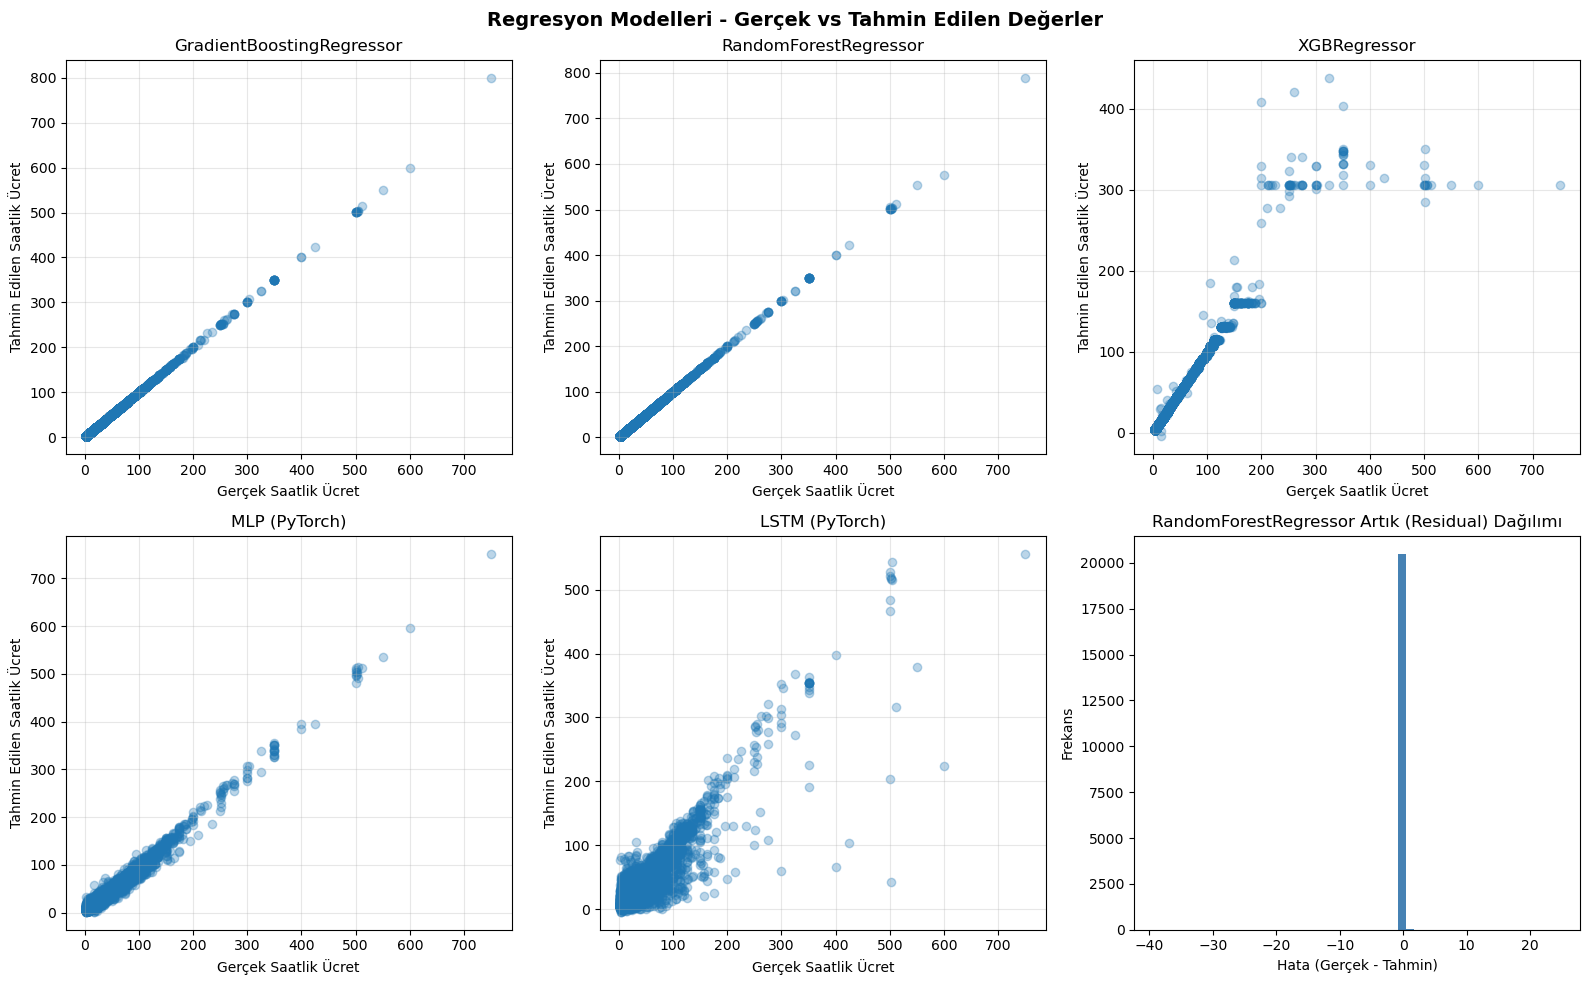

Kaydedildi: ayham_regression_r2_comparison.png


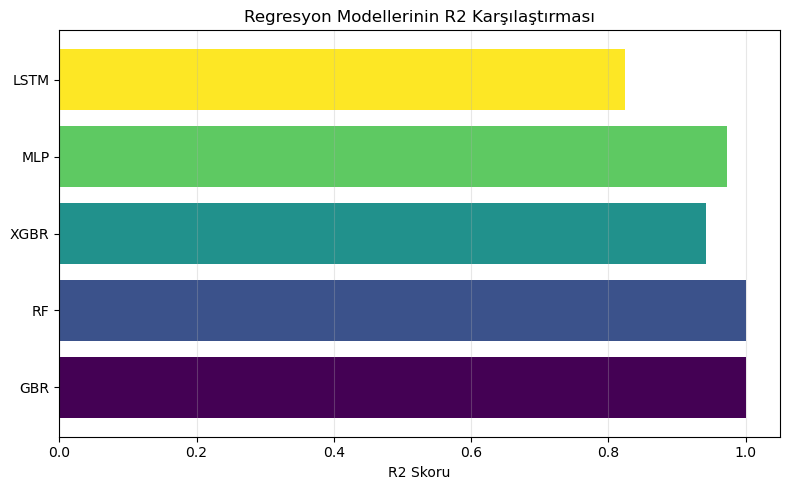


Ayham için regresyon projesi görselleri oluşturuldu.


In [11]:
# =====================================================
# HÜCRE 10 – REGRESYON GÖRSELLERİ VE SONUÇLARIN ÖZETLENMESİ
# Bu hücre:
# 1) Farklı modeller için gerçek vs tahmin edilen saatlik ücret grafikleri çizilir
# 2) Rastgele seçilen bir model için hata (residual) dağılımı gösterilir
# 3) Tüm modellerin R2 skorları bar grafiği ile özetlenir
# =====================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle("Regresyon Modelleri - Gerçek vs Tahmin Edilen Değerler", fontsize=14, fontweight="bold")

model_predictions = [
    (y_pred_gbr,   "GradientBoostingRegressor", axes[0, 0]),
    (y_pred_rf,    "RandomForestRegressor",     axes[0, 1]),
    (y_pred_xgbr,  "XGBRegressor",              axes[0, 2]),
    (y_pred_mlp,   "MLP (PyTorch)",             axes[1, 0]),
    (y_pred_lstm,  "LSTM (PyTorch)",            axes[1, 1]),
]

for y_hat, label, ax in model_predictions:
    ax.scatter(y_test_np, y_hat, alpha=0.3)
    ax.set_xlabel("Gerçek Saatlik Ücret")
    ax.set_ylabel("Tahmin Edilen Saatlik Ücret")
    ax.set_title(label)
    ax.grid(alpha=0.3)

# Rastgele bir model (örnek: RandomForestRegressor) için residual dağılımı
residuals_rf = y_test_np - y_pred_rf
ax = axes[1, 2]
ax.hist(residuals_rf, bins=50, color="steelblue")
ax.set_title("RandomForestRegressor Artık (Residual) Dağılımı")
ax.set_xlabel("Hata (Gerçek - Tahmin)")
ax.set_ylabel("Frekans")

plt.tight_layout()
plt.savefig("ayham_regression_diagnostic_plots.png", dpi=200, bbox_inches="tight")
print("Kaydedildi: ayham_regression_diagnostic_plots.png")
plt.show()

# Modellerin R2 skorlarının özetlenmesi
model_names = [
    "GBR",
    "RF",
    "XGBR",
    "MLP",
    "LSTM"
]

r2_scores = [
    r2_score(y_test_np, y_pred_gbr),
    r2_score(y_test_np, y_pred_rf),
    r2_score(y_test_np, y_pred_xgbr),
    r2_score(y_test_np, y_pred_mlp),
    r2_score(y_test_np, y_pred_lstm),
]

plt.figure(figsize=(8, 5))
plt.barh(model_names, r2_scores, color=plt.cm.viridis(np.linspace(0, 1, len(model_names))))
plt.xlabel("R2 Skoru")
plt.title("Regresyon Modellerinin R2 Karşılaştırması")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig("ayham_regression_r2_comparison.png", dpi=200, bbox_inches="tight")
print("Kaydedildi: ayham_regression_r2_comparison.png")
plt.show()

print("\nAyham için regresyon projesi görselleri oluşturuldu.")


In [12]:
# =====================================================
# HÜCRE 11 – REGRESYON MODELLERİ İÇİN ÖZET PERFORMANS TABLOSU
# Bu hücre:
# 1) Sklearn ve PyTorch modellerinin sonuçlarını tek bir tabloda birleştirir
# 2) Her model için R2, MSE, RMSE, MAE, MAPE metriklerini gösterir
# 3) Tabloyu CSV dosyası olarak kaydeder
# =====================================================

# Sklearn ve PyTorch sonuçlarını birleştir
tum_sonuclar = sklearn_results + pytorch_results

tum_df = pd.DataFrame(tum_sonuclar).round(4)

print("\nTÜM REGRESYON MODELLERİ İÇİN PERFORMANS ÖZETİ")
print(tum_df.to_string(index=False))

tum_df.to_csv("ayham_tum_regresyon_modelleri_performans_ozeti.csv", index=False)
print("\nKaydedildi: ayham_tum_regresyon_modelleri_performans_ozeti.csv")



TÜM REGRESYON MODELLERİ İÇİN PERFORMANS ÖZETİ
                    Model     R2      MSE    RMSE    MAE    MAPE        Mimari
GradientBoostingRegressor 0.9998   0.1562  0.3952 0.0721  0.2666           NaN
    RandomForestRegressor 0.9999   0.1090  0.3302 0.0054  0.0014           NaN
             XGBRegressor 0.9427  51.5608  7.1806 0.5564  1.2948           NaN
                      MLP 0.9720  25.2121  5.0212 3.3696 19.2651      128-64-1
                     LSTM 0.8245 157.9192 12.5666 5.6655 30.6309 LSTM(64)-32-1

Kaydedildi: ayham_tum_regresyon_modelleri_performans_ozeti.csv


Kaydedildi: ayham_regression_diagnostic_plots.png


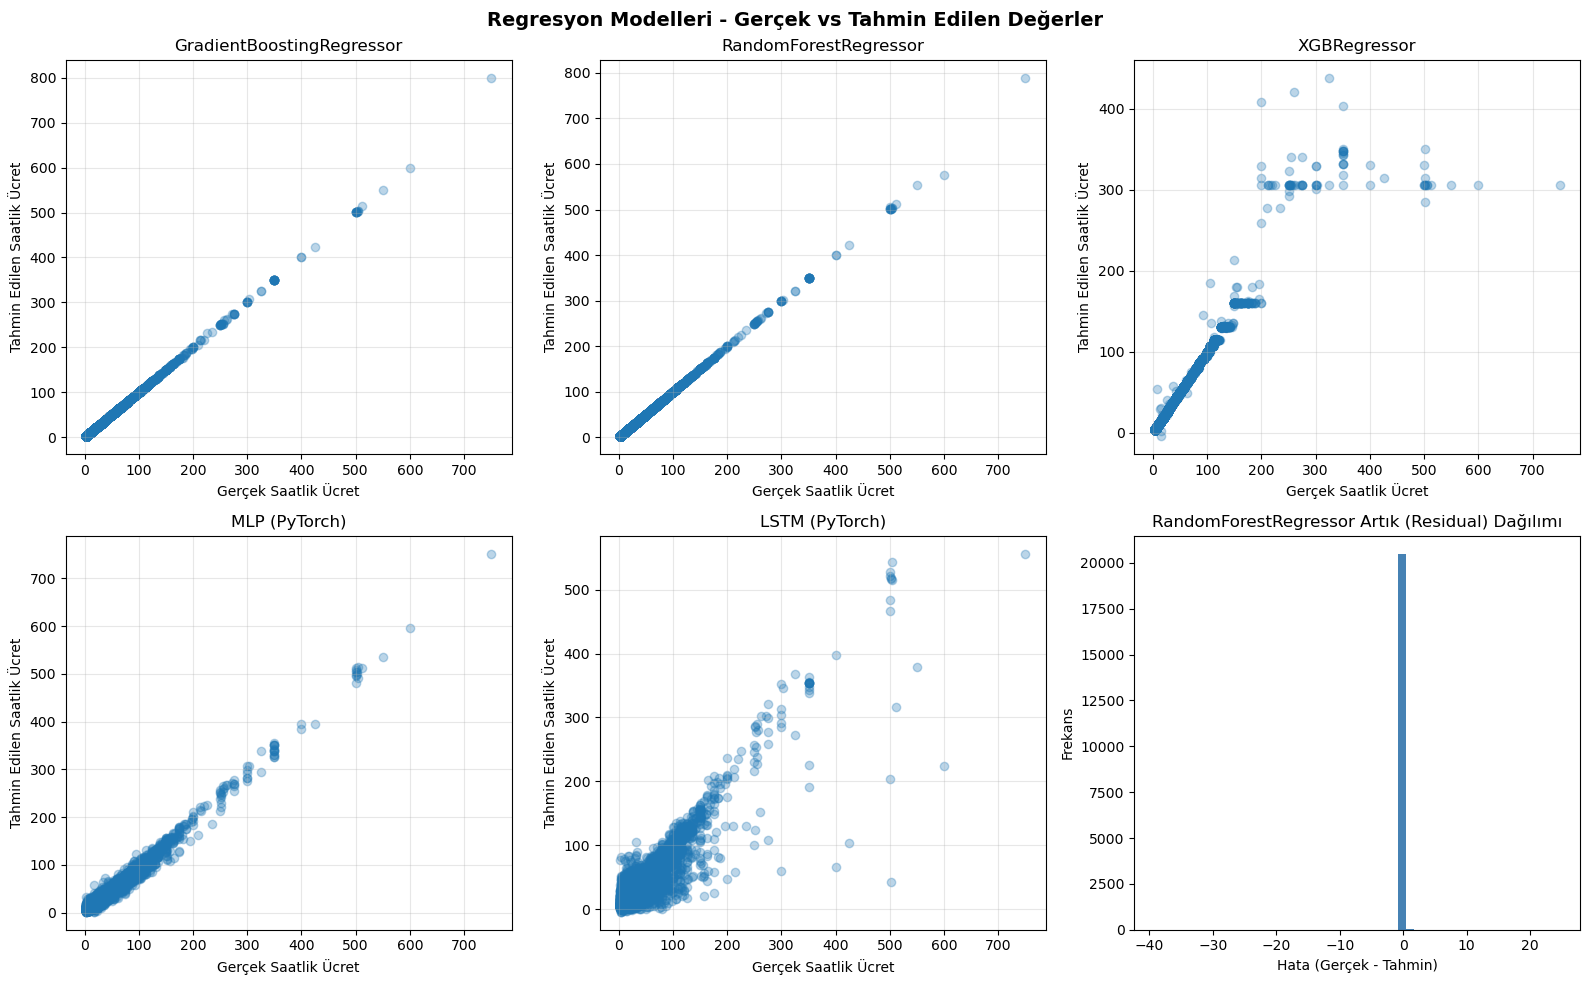

Kaydedildi: ayham_regression_r2_comparison.png


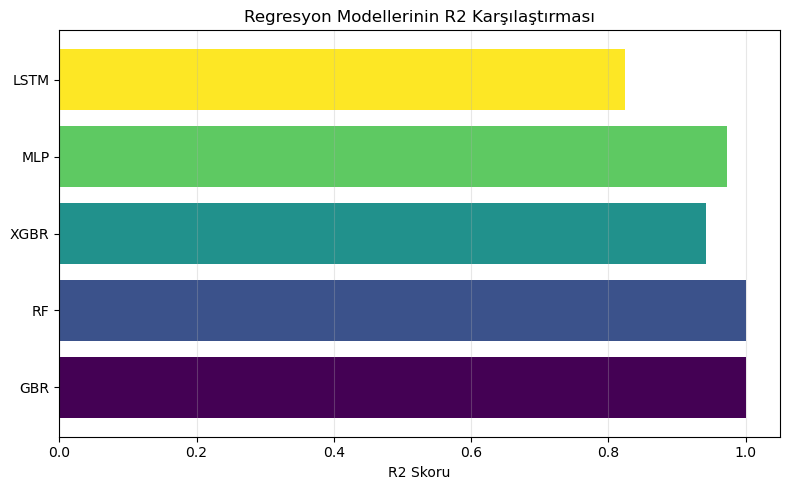


Ayham için regresyon projesi görselleri oluşturuldu.


In [13]:
# =====================================================
# HÜCRE 12 – REGRESYON GÖRSELLERİ VE SONUÇLARIN ÖZETLENMESİ
# Bu hücre:
# 1) Farklı modeller için gerçek vs tahmin edilen saatlik ücret grafikleri çizer
# 2) Bir model için hata (residual) dağılımını gösterir
# 3) Tüm modellerin R2 skorlarını bar grafiği ile özetler
# =====================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle("Regresyon Modelleri - Gerçek vs Tahmin Edilen Değerler", fontsize=14, fontweight="bold")

model_predictions = [
    (y_pred_gbr,   "GradientBoostingRegressor", axes[0, 0]),
    (y_pred_rf,    "RandomForestRegressor",     axes[0, 1]),
    (y_pred_xgbr,  "XGBRegressor",              axes[0, 2]),
    (y_pred_mlp,   "MLP (PyTorch)",             axes[1, 0]),
    (y_pred_lstm,  "LSTM (PyTorch)",            axes[1, 1]),
]

for y_hat, label, ax in model_predictions:
    ax.scatter(y_test_np, y_hat, alpha=0.3)
    ax.set_xlabel("Gerçek Saatlik Ücret")
    ax.set_ylabel("Tahmin Edilen Saatlik Ücret")
    ax.set_title(label)
    ax.grid(alpha=0.3)

# RandomForestRegressor için residual dağılımı
residuals_rf = y_test_np - y_pred_rf
ax = axes[1, 2]
ax.hist(residuals_rf, bins=50, color="steelblue")
ax.set_title("RandomForestRegressor Artık (Residual) Dağılımı")
ax.set_xlabel("Hata (Gerçek - Tahmin)")
ax.set_ylabel("Frekans")

plt.tight_layout()
plt.savefig("ayham_regression_diagnostic_plots.png", dpi=200, bbox_inches="tight")
print("Kaydedildi: ayham_regression_diagnostic_plots.png")
plt.show()

# Modellerin R2 skorlarının özetlenmesi
model_names = [
    "GBR",
    "RF",
    "XGBR",
    "MLP",
    "LSTM"
]

r2_scores = [
    r2_score(y_test_np, y_pred_gbr),
    r2_score(y_test_np, y_pred_rf),
    r2_score(y_test_np, y_pred_xgbr),
    r2_score(y_test_np, y_pred_mlp),
    r2_score(y_test_np, y_pred_lstm),
]

plt.figure(figsize=(8, 5))
plt.barh(model_names, r2_scores, color=plt.cm.viridis(np.linspace(0, 1, len(model_names))))
plt.xlabel("R2 Skoru")
plt.title("Regresyon Modellerinin R2 Karşılaştırması")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig("ayham_regression_r2_comparison.png", dpi=200, bbox_inches="tight")
print("Kaydedildi: ayham_regression_r2_comparison.png")
plt.show()

print("\nAyham için regresyon projesi görselleri oluşturuldu.")


In [1]:
!pip install torch --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
